# 处理下载的数据

In [1]:
import os
data_dir = "/home/dingziming/下载/jena_climate"
fname = os.path.join(data_dir, "jena_climate_2009_2016.csv")

f = open(fname)
data = f.read()
f.close()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


# 解析数据 将数据转化为浮点数

In [2]:
import numpy as np

# 设置随机种子
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
float_data = np.zeros((len(lines),len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    float_data[i,:] = values

# 绘制温度时间序列

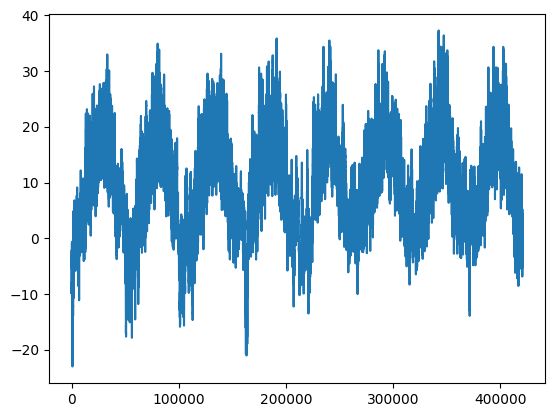

In [3]:
import matplotlib.pyplot as plt
temp = float_data[:,1]
plt.plot(range(len(temp)),temp)
plt.show()

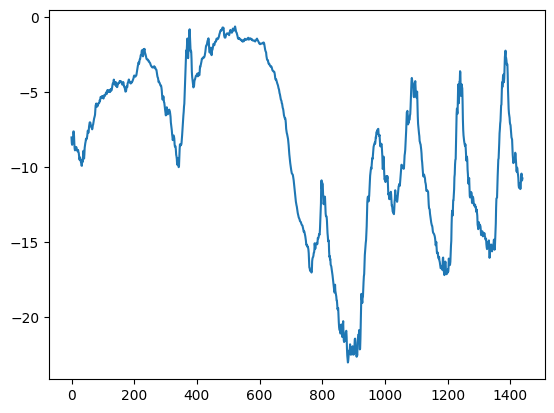

In [4]:
plt.plot(range(1440), temp[:1440])
plt.show()

# 数据标准化

In [5]:
mean = float_data[:20000].mean(axis=0)
float_data -= mean
std = float_data[:20000].std(axis= 0)
float_data /= std

# 生成时间序列样本及其目标的生成器

In [6]:
def generator(data, lookback, delay, min_index, max_index, shuffle= False, batch_size=128,step = 6):
    """
    数据生成器函数，用于生成时间序列数据的样本和目标
    参数:
    data: 输入数据，通常是多维数组
    lookback: 输入数据的时间步长，即回看多长时间的历史数据
    delay: 预测目标与当前数据点之间的时间间隔
    min_index: 数据的最小索引
    max_index: 数据的最大索引，如果为None则自动计算
    shuffle: 是否打乱数据顺序，默认为False
    batch_size: 每个批次的样本数量，默认为128
    step: 采样步长，默认为6，即每隔6个时间步采样一次
    返回:
    生成器，产生(samples, targets)元组，其中samples是输入数据，targets是对应的目标值
    """
    if max_index is None:
        # 如果没有提供最大索引，则自动设置为数据长度减去延迟和1 减去1是数组以0开头
        max_index = len(data) - delay -1
    # 初始化索引，从最小索引加上回看时间步长开始
    i = min_index +lookback
    while 1:
        # 如果shuffle为True，随机选择行索引 也就是随机采样
        if shuffle:
            # 从min_index+lookback到max_index之间随机选择batch_size个行索引
            rows = np.random.randint(min_index+lookback, max_index, size = batch_size)

        else:
            # 如果shuffle为False，则按顺序选择行索引
            # 如果当前索引加上批次大小超过最大索引，则重置为起始位置
            if i+ batch_size >=max_index:
                i = min_index +lookback
            # 创建从i到i+batch_size的连续索引
            rows = np.arange(i, i+batch_size)
            # 更新i的值，为下一次循环做准备
            i += len(rows)

        # 创建样本数组，形状为(batch_size, lookback//6, data.shape[-1])
        samples = np.zeros((batch_size, lookback//6, data.shape[-1]))

        # 创建目标数组，形状为(len(rows),)
        targets = np.zeros((len(rows),))
        # 遍历每行数据，填充样本和目标
        for j, row in enumerate(rows):
            # 计算历史数据的索引范围，从row-lookback到row，步长为step
            indices = range(rows[j] - lookback, rows[j], step)
            # 填充样本数据
            samples[j] = data[indices]
            # 填充目标数据，取row+delay位置的第二个元素
            targets[j] = data[rows[j] + delay][1]
        # 生成样本和目标
        yield samples, targets

## 创建三个生成器

In [7]:
lookback = 1440
delay = 144
step = 6
batch_size = 128

# 创建训练数据生成器
train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step, batch_size=batch_size)

val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, step=step, batch_size=batch_size)

test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, step=step, batch_size=batch_size)

# 为了查看整个验证集 需要从val_gen中抽取多少次
val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size

# 创建一个模型基准

In [8]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    return (np.mean(batch_maes))

print("mae of naive method: ", evaluate_naive_method())

mae of naive method:  0.33551756286169604


# 构建并训练一个密集连击网络

In [9]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback//step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer= RMSprop(0.001), loss='mae')

history = model.fit(
    train_gen,
    steps_per_epoch=200,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_steps
)

/home/dingziming/anaconda3/envs/DL-310/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1758709827.100705    6446 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Epoch 1/20


2025-09-24 18:30:27.835668: I external/local_xla/xla/service/service.cc:163] XLA service 0x719c8c005a10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-24 18:30:27.835687: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 Laptop GPU, Compute Capability 8.9
2025-09-24 18:30:27.858131: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-24 18:30:27.903904: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


 65/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8976

I0000 00:00:1758709828.364889    6550 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.3126 - val_loss: 0.8593
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.7388 - val_loss: 0.4643
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.5086 - val_loss: 0.5016
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.3951 - val_loss: 0.4287
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.3522 - val_loss: 0.3799
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.3316 - val_loss: 0.4314
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.3184 - val_loss: 0.3785
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.3065 - val_loss: 0.3779
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.2990 - val_loss: 0.3678
Epoch 10/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2919 - val_loss: 0.3719
Epoch 11/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.2848 - val_loss: 0.3703
Epoch 12/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

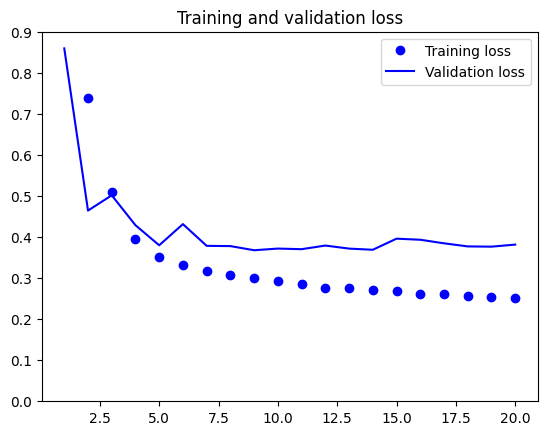

In [10]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.ylim(0, 0.9)  # 设置y轴范围为0到0.4
plt.show()


# 第一个循环网络基准

In [11]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer = RMSprop(), loss= "mae")

history = model.fit(
    train_gen,
    steps_per_epoch=500,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_steps
)

Epoch 1/20


/home/dingziming/anaconda3/envs/DL-310/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3843

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.ylim(0, 0.9)  # 设置y轴范围为0到0.4
plt.show()

In [ ]:
# 使用Dropout来降低过拟合
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer = RMSprop(), loss= "mae")

history = model.fit(
    train_gen,
    steps_per_epoch= 500,
    epochs= 20,
    validation_data= val_gen,
    validation_steps= val_steps
)

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label= "Training loss")
plt.plot(epochs, val_loss, "b", label= "Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.ylim(0, 0.9)  # 设置y轴范围为0到0.4
plt.show()

In [ ]:
# 使用循环层堆叠
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, dropout= 0.1, recurrent_dropout= 0.2, return_sequences=True, input_shape= (None, float_data.shape[-1])))
model.add(layers.GRU(64, dropout= 0.1, recurrent_dropout= 0.5,activation= "relu"))
model.add(layers.Dense(1))
model.compile(optimizer= RMSprop(), loss= "mae")

history = model.fit(
    train_gen,
    steps_per_epoch=500,
    epochs=40,
    validation_data=val_gen,
    validation_steps=val_steps
)

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo",label= "Training loss")
plt.plot(epochs, val_loss, "b", label= "Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.ylim(0, 0.9)  # 设置y轴范围为0到0.4
plt.show()

In [15]:
# 使用单向LSTM
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

max_features =10000
maxlen = 500
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen= maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation= "sigmoid"))
model.compile(optimizer= "adam", loss= "binary_crossentropy", metrics= ["accuracy"])

history = model.fit(
    x_train,
    y_train,
    epochs= 10,
    batch_size= 128,
    validation_split= 0.2
)

Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/tf-keras-datasets/imdb.npz: None -- [Errno 104] Connection reset by peer

In [ ]:
# 创建一个双向LSTM 用于imdb数据集训练比较训练效果g
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation= "sigmoid"))

model.compile(optimizer= "adam", loss= "binary_crossentropy", metrics= ["accuracy"])

history = model.fit(x_train, y_train, epochs= 10, batch_size= 128, validation_split= 0.2)


In [16]:
# 使用双向GRU进行温度预测
model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32, input_shape=(None, float_data.shape[-1]))))
model.add(layers.Dense(1))

model.compile(optimizer= RMSprop(), loss= "mae")

history = model.fit(
    train_gen,
    steps_per_epoch= 500,
    epochs= 40,
    validation_data = val_gen,
    validation_steps= val_steps
)

Epoch 1/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.3494 - val_loss: 0.3170
Epoch 2/40
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3232

KeyboardInterrupt: 